In [1]:
import math 
import numpy as np
import scipy as sp
import bokeh as bk
import scipy.optimize as opt
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import xlwt
from bokeh.plotting import figure, output_file, show

### The loglikelihood of a 3D time-varying t-copula

In [2]:
def tCopula_3D_TVP_LL(theta,U,exog12,exog13,exog23,exogNU):
    '''Returns -ve LL of the 3-dimension Student R copula''' 
    T,N = U.shape
    
    k12 = exog12.shape[1]
    k13 = exog13.shape[1]
    k23 = exog23.shape[1]
    kNU = exogNU.shape[1]
    
    beta12 = theta[:k12]
    beta13 = theta[k12:k12+k13]
    beta23 = theta[k12+k13:k12+k13+k23]
    betaNU = theta[k12+k13+k23:]
    
    NUt = 2+np.exp(np.dot(exogNU,betaNU))
    rho12 = -1+2/(1+np.exp(np.dot(-exog12,beta12)))
    rho13 = -1+2/(1+np.exp(np.dot(-exog13,beta13)))
    rho23 = -1+2/(1+np.exp(np.dot(-exog23,beta23)))
    
    RHOt = np.empty((3,3,T))
    counter = 0
    for tt in np.arange(T):
#        allRHOt = np.concatenate((rho12[:tt],rho13[:tt],rho23[:tt]),axis=0)
        allRHOt = np.vstack((rho12[tt],rho13[tt],rho23[tt]))
        RHOt[:,:,tt] = theta2rho(allRHOt)
        if is_pos_def(RHOt[:,:,tt])== 0:
            counter = counter+1;
            
    if counter > 0:
        LL=1e7
    else:
        trmU = np.empty((T,N))
        LLa = np.empty((T,1))
        
        for tt in np.arange(T):
            NU = NUt[tt]
            
            if NU < 100:
                trmU[tt,:] = stats.t.ppf(U[tt,:],NU)
            else:
                trmU[tt,:] = stats.norm.ppf(U[tt,:])
    
            allRHOt = np.vstack((rho12[tt],rho13[tt],rho23[tt]))
            RHO = theta2rho(allRHOt)
            
            LLa[tt] = math.lgamma((NU+N)/2) + (N-1)*math.lgamma(NU/2)-N*math.lgamma((NU+1)/2)-0.5*math.log(np.linalg.det(RHO))
            t1 = trmU[tt,:].dot(np.linalg.inv(RHO)).dot(trmU[tt,:])
            #np.reduce(np.dot,[trmU[tt,:],np.linalg.inv(RHO),trmU[tt,:]]) 
            # Equiv. to t0 =                        
            LLa[tt] = LLa[tt] - ((NU+N)/2)*np.log(1+t1/NU)    
            LLa[tt] = LLa[tt] + ((NU+1)/2)*sum(np.log(1+(trmU[tt,:]**2/NU)))
        LL = -sum(LLa)
        print(LL)
        return LL
        #return LL,rho12,rho13,rho23,NUt


Produce M samples of d-dimensional multivariate t distribution Input: mu = mean (d dimensional numpy array or scalar) Sigma = scale matrix (dxd numpy array) df = degrees of freedom N = # of samples to produce

In [3]:
def multivariatet(mu,Sigma,df,N):

   dim = len(Sigma)
   g = np.tile(np.random.gamma(df/2.,2./df,M),(dim,1)).T
   Z = np.random.multivariate_normal(np.zeros(dim),Sigma,N)
   return mu + Z/np.sqrt(g)

Multivariate t-student density: output: the density of the given element input: x = parameter (d dimensional numpy array or scalar) mu = mean (d dimensional numpy array or scalar) Sigma = scale matrix (dxd numpy array) df = degrees of freedom d: dimension

In [4]:
def multivariate_t_distribution(x,mu,Sigma,df):
   d = len(Sigma)
   Num = gamma(1. * (d+df)/2)
   Denom = ( gamma(1.*df/2) * pow(df*pi,1.*d/2) * pow(np.linalg.det(Sigma),1./2) * pow(1 + (1./df)*np.dot(np.dot((x - mu),np.linalg.inv(Sigma)), (x - mu)),1.* (d+df)/2))
   d = 1. * Num / Denom 
   return d

### Check if a matrix is positive and definite output: 1 (or 0) if the matrix is positive and definite input: x = the matrix (d dimensional numpy array)

In [5]:
def is_pos_def(x):
    
    return np.all(np.linalg.eigvals(x) > 0)

The code below converds code from Kendall's tau to Pearson's correlation

In [6]:
def theta2rho(theta):
    m = len(theta)
    k = int((1+np.sqrt(1+8*m))/2)
    
    out1 = np.empty((k,k))
    counter=0
    for ii in np.arange(k):
        for jj in np.arange(ii,k):
            if ii==jj:
                out1[ii,jj]=1
            else:
                out1[ii,jj]=theta[counter]
                out1[jj,ii]=theta[counter]
                counter = counter+1
    return out1

The code is to generate random variables from a multivaraite t-distribution

In [7]:
def mvtrnd(C,df,cases):
    (m,n) = C.shape
    s = np.diag(C)
    s_not_1 = s != 1
    if any(s_not_1):
        C = C/np.sqrt(s*s.T)
    T = np.linalg.cholesky(C)
        
    r = np.dot(np.random.randn(cases,len(T)),T)
    x = np.sqrt(np.random.gamma(df/2,2,cases)/df)
    r = r/x    # No need the ./x(:,ones(n,1)) as Python does elem by elem operations
    return r
 

The code is to generate random variables based on a t-copula with the degrees of freedom and the VCV Generates random vectors froma t-copula output: u = random vectors (NxP matrix). Each column of u is a sample from a Uniiform(0,1) marginal distribution input: Rho = PxP llinear correlation matrix nu = degrees of freedom n = N random vectors

In [8]:
def tCop_rnd(Rho,nu,n):
    mvtVar = mvtrnd(Rho,nu,n)
    u = stats.t.cdf(mvtVar,nu)
    return u

The below is the script to generate the tri-variate copula, and then estimate the parameters of the model

/home/ak/anaconda3/envs/mmd-kernels/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.sin is deprecated and will be removed in SciPy 2.0.0, use numpy.sin instead
  
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.cos is deprecated and will be removed in SciPy 2.0.0, use numpy.cos instead
  import sys
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.sin is deprecated and will be removed in SciPy 2.0.0, use numpy.sin instead
  
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.cos is deprecated and will be removed in SciPy 2.0.0, use numpy.cos instead
  if __name__ == '__main__':


[16.88009286]
[16.88009286]
[49.96378507]
[622.90194818]
[16.88009286]
[144.21607069]
[-5.96819936]
[-6.00174249]
[-6.00132245]
[-5.99755659]
[-6.00174249]
[51.69966891]
[50.86433369]
[-6.00174249]
[-6.39606582]
[6.76621198]
[-9.51750507]
[-9.51724333]
[-9.51706496]
[-9.51750507]
[-51.84856062]
[564.66590918]
[-51.84856062]
[49.31504231]
[-60.58683078]
[-61.5609776]
[-61.58445176]
[-61.58230176]
[-61.57528284]
[-61.58445176]
[-38.75739452]
[21.22578137]
[-61.58445176]
[-49.27345204]
[-58.96340841]
[-61.67389424]
[-61.67437666]
[-61.67437571]
[-61.67435951]
[-61.67437666]
[-74.83513221]
[518.653367]
[-74.83513221]
[27.83635018]
[-91.03719397]
[-90.90041464]
[-91.11241053]
[-91.11258615]
[-91.10662109]
[-91.11258615]
[-75.93861759]
[-15.19066734]
[-91.11258615]
[-77.99853101]
[-90.77043356]
[-91.75332655]
[-91.75323447]
[-91.75329067]
[-91.75332655]
[-138.15292993]
[-161.61616019]
[-161.20119693]
[-158.11981318]
[-161.61616019]
[-160.59202823]
[-158.9403293]
[-161.60881114]
[-161.6936611

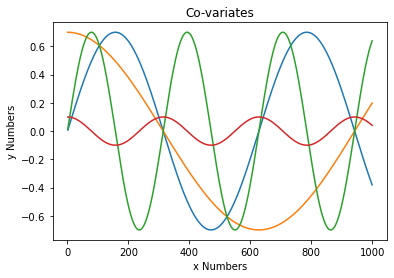

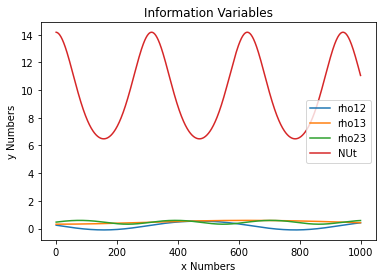

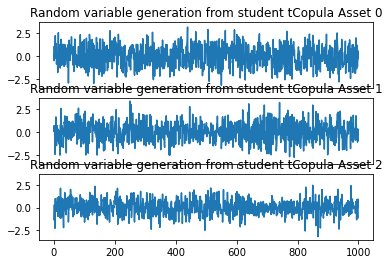

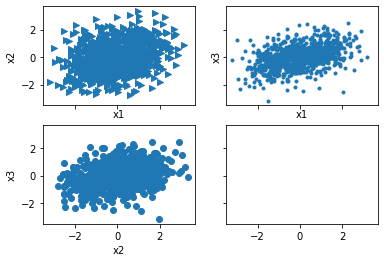

In [9]:
if  __name__=="__main__":
    #%% Time-varying trivariate t-Copula (Simulation)
    np.random.seed(10)
    T = 1000
    x1 = np.ones([T,1])
    x2 = np.reshape(0.7*sp.sin((np.arange(1,T+1)/100)),(T,1))
    x3 = np.reshape(0.7*sp.cos((np.arange(1,T+1)/200)),(T,1))
    x4 = np.reshape(0.7*sp.sin((np.arange(1,T+1)/50)),(T,1))
    x5 = np.reshape(0.1*sp.cos((np.arange(1,T+1)/50)),(T,1))
    x = np.arange(1,T+1)

    fig1, ax1 = plt.subplots(1,1)
    ax1.plot(x,x2,x,x3,x,x4,x,x5)
    ax1.set_title('Co-variates')
    ax1.set_xlabel('x Numbers')
    ax1.set_ylabel('y Numbers')

    beta12 = np.array([[0.5],[-1]])
    beta13 = np.array([[1],[-0.5]])
    beta23 = np.array([[1],[0.5]])
    betaNU = np.array([[2],[5]])
    
    exog12 = np.concatenate((x1,x2),axis=1)
    exog13 = np.concatenate((x1,x3),axis=1)
    exog23 = np.concatenate((x1,x4),axis=1)
    exogNU = np.concatenate((x1,x5),axis=1)
    
    rho12 = -1+2/(1+np.exp(np.dot(-exog12,beta12)))
    rho13 = -1+2/(1+np.exp(np.dot(-exog13,beta13)))
    rho23 = -1+2/(1+np.exp(np.dot(-exog23,beta23)))
    NUt = 2+np.exp(np.dot(exogNU,betaNU))
        
    fig2 = plt.figure()
    ax1 = fig2.add_subplot(111)
    ax1.plot(x,rho12,label='rho12')
    ax1.plot(x,rho13,label='rho13')
    ax1.plot(x,rho23,label='rho23')
    ax1.plot(x,NUt,label='NUt')
    plt.title('Information Variables')
    plt.xlabel('x Numbers')
    plt.ylabel('y Numbers')
    plt.legend()

    RHOt = np.empty((3,3,T))
    for tt in np.arange(T):
        allRHOt = np.vstack((rho12[tt],rho13[tt],rho23[tt]))
        RHOt[:,:,tt] = theta2rho(allRHOt)
        if is_pos_def(RHOt[:,:,tt])==0:
            print(tt)
    
    dataU = np.zeros((T,3))
    data = np.zeros((T,3))

    for tt in np.arange(T):
        dataU[tt,:] = tCop_rnd(RHOt[:,:,tt],NUt[tt],1)
        data[tt,:] = stats.norm.ppf(dataU[tt,:])


    fig3,axes = plt.subplots(3,1,sharex=True,sharey=True)
    for i in np.arange(3):
        axes[i].plot(data[:,i])
        title = 'Random variable generation from student tCopula Asset '
        axes[i].set_title(title+str(i))
        
    fig3.subplots_adjust(hspace=0.15)

    fig4,axes = plt.subplots(2,2,sharex=True,sharey=True)
    axes[0,0].scatter(data[:,0],data[:,1], marker = ">"),axes[0,0].set_xlabel('x1'),axes[0,0].set_ylabel('x2')
    axes[0,1].scatter(data[:,0],data[:,2], marker = "."),axes[0,1].set_xlabel('x1'),axes[0,1].set_ylabel('x3')
    axes[1,0].scatter(data[:,1],data[:,2]),axes[1,0].set_xlabel('x2'),axes[1,0].set_ylabel('x3')

    tCopData = dataU

    # Time-varying trivariate t-copula (Estimation)
    theta0 = np.zeros(8)
    Udata = tCopData
    thetahat_powell = opt.fmin_powell(tCopula_3D_TVP_LL,theta0,args=(Udata,exog12,exog13,exog23,exogNU,))